In [1]:
import os
import pandas as pd
import supereeg as se
import numpy as np
import copy
import nibabel as nib
from nilearn import plotting as ni_plt
from nilearn.image import resample_img
from nilearn import datasets, image
from scipy.spatial.distance import pdist, cdist
import scipy 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.colors as mplcol
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat
from decode_helpers.helpers import find_features

/Users/lucyowen/.pyenv/versions/3.7.2/envs/my-data-project/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:

def _near_neighbor(bo, full_bo): #TODO: should this be part of bo.get_locs() or Brain.__init__, or possibly model.__init__?
    """
    Finds the nearest voxel for each subject's electrode location and uses
    that as revised electrodes location matrix in the prediction.

    Parameters
    ----------

    bo : Brain object
        Brain object to update

    full_bo : Brain object
        Brain object for the nearests locations used to predict


    Returns
    ----------
    bo : Brain object
        A new updated brain object

    """

    nbo = copy.deepcopy(bo) #FIXME: copying is expensive...
    nbo.orig_locs = nbo.locs
    d = cdist(nbo.locs, full_bo.locs, metric='Euclidean')
    for i in range(len(nbo.locs)):
        min_ind = list(zip(*np.where(d == d[i].min())))[0]
        nbo.data.iloc[:, min_ind[0]] = full_bo.data.iloc[:, min_ind[1]]
    return nbo



In [58]:
def interp_corr(locs, corrs, width=10, vox_size=10, outfile=None, save_nii=None):
    nii = se.load('std', vox_size=vox_size)
    full_locs = nii.get_locs().values
    W = np.exp(se.helpers._log_rbf(full_locs, locs, width=width))
    interp_corrs =  np.dot(corrs, W.T)
    bo_nii = se.Brain(data=interp_corrs, locs=full_locs)
    nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
    ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0)
    #ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

    if save_nii:
        nii_bo.save(save_nii)
        
    if not outfile is None:
        plt.savefig(outfile)
    else:
        plt.show()

In [99]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
ddir = '../../data/'

In [5]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [28]:
factors=700

In [29]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [30]:
pieman_data = loadmat(pieman_name)

In [31]:
debug = False

In [32]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [33]:
data = np.array(data)
conds = np.array(conds)

/Users/lucyowen/.pyenv/versions/3.7.2/envs/my-data-project/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [34]:
cond = pieman_conds[0]

In [35]:
cond

'intact'

In [36]:
importance = find_features(data[conds == cond], dims=int(factors))


In [37]:
min_sub = importance - importance.min()
importance_normed = min_sub/(importance.max() - importance.min())
for i, v in enumerate(importance_normed):
    print('Feature: %0d, Score: %.5f' % (i, v))

Feature: 0, Score: 0.98023
Feature: 1, Score: 0.97277
Feature: 2, Score: 0.98484
Feature: 3, Score: 0.97039
Feature: 4, Score: 0.99197
Feature: 5, Score: 0.96281
Feature: 6, Score: 0.98770
Feature: 7, Score: 0.96962
Feature: 8, Score: 0.99016
Feature: 9, Score: 0.97647
Feature: 10, Score: 0.93396
Feature: 11, Score: 0.98498
Feature: 12, Score: 0.98160
Feature: 13, Score: 0.97606
Feature: 14, Score: 0.99260
Feature: 15, Score: 0.96428
Feature: 16, Score: 0.96267
Feature: 17, Score: 0.98656
Feature: 18, Score: 0.99176
Feature: 19, Score: 0.98696
Feature: 20, Score: 0.97207
Feature: 21, Score: 0.98264
Feature: 22, Score: 0.98813
Feature: 23, Score: 0.99799
Feature: 24, Score: 0.97432
Feature: 25, Score: 0.98899
Feature: 26, Score: 0.95425
Feature: 27, Score: 0.84779
Feature: 28, Score: 0.97928
Feature: 29, Score: 0.95811
Feature: 30, Score: 0.97699
Feature: 31, Score: 0.99281
Feature: 32, Score: 0.96523
Feature: 33, Score: 0.99230
Feature: 34, Score: 0.68120
Feature: 35, Score: 0.98706
Fe

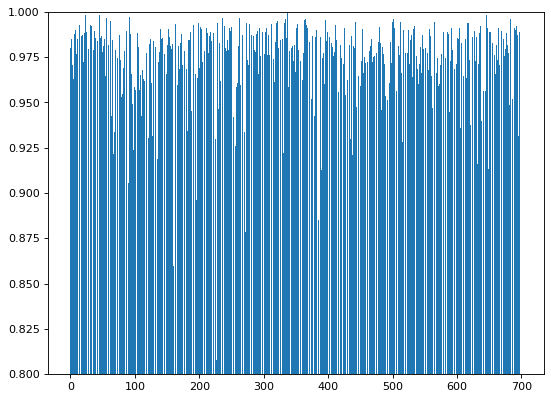

In [40]:
from matplotlib import pyplot
# plot feature importance
pyplot.figure(figsize=(8, 6), dpi=80)
pyplot.bar([x for x in range(len(importance_normed))], importance_normed)
pyplot.ylim([.8, 1])
pyplot.show()



In [45]:
centers.shape

(700, 3)

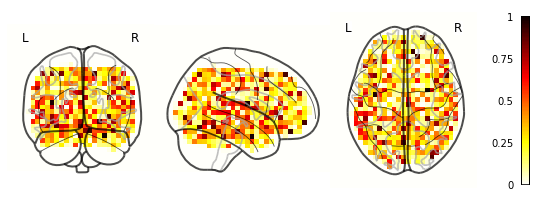

In [50]:

## use width and voxel == 2 for paper fig
interp_corr(centers,  np.atleast_2d(importance_normed), width=6, vox_size=6, outfile=None, save_nii=None)

In [135]:
importance = find_features(data[conds == c], dims=int(factors))

In [136]:
importance

array([0.99998146, 0.99997577, 0.99998498, 0.99997396, 0.99999041,
       0.99996818, 0.99998716, 0.99997337, 0.99998903, 0.99997859,
       0.99994619, 0.99998508, 0.99998251, 0.99997829, 0.99999089,
       0.9999693 , 0.99996807, 0.99998629, 0.99999025, 0.9999866 ,
       0.99997524, 0.9999833 , 0.99998748, 0.99999501, 0.99997695,
       0.99998814, 0.99996166, 0.99988049, 0.99998073, 0.9999646 ,
       0.99997899, 0.99999105, 0.99997003, 0.99999066, 0.99975348,
       0.99998667, 0.99998041, 0.99998856, 0.99996799, 0.99998546,
       0.99995312, 0.99998646, 0.99998413, 0.99998119, 0.99998912,
       0.99999536, 0.99998214, 0.99998553, 0.99998643, 0.99998319,
       0.99997951, 0.99998223, 0.99997712, 0.99998514, 0.99996969,
       0.99995973, 0.99999396, 0.99994614, 0.99994815, 0.99998243,
       0.99997035, 0.99988631, 0.99999286, 0.99993689, 0.99995261,
       0.99998451, 0.99997227, 0.9999366 , 0.99994589, 0.99996549,
       0.99998026, 0.99997371, 0.99997746, 0.99997721, 0.99998

intact


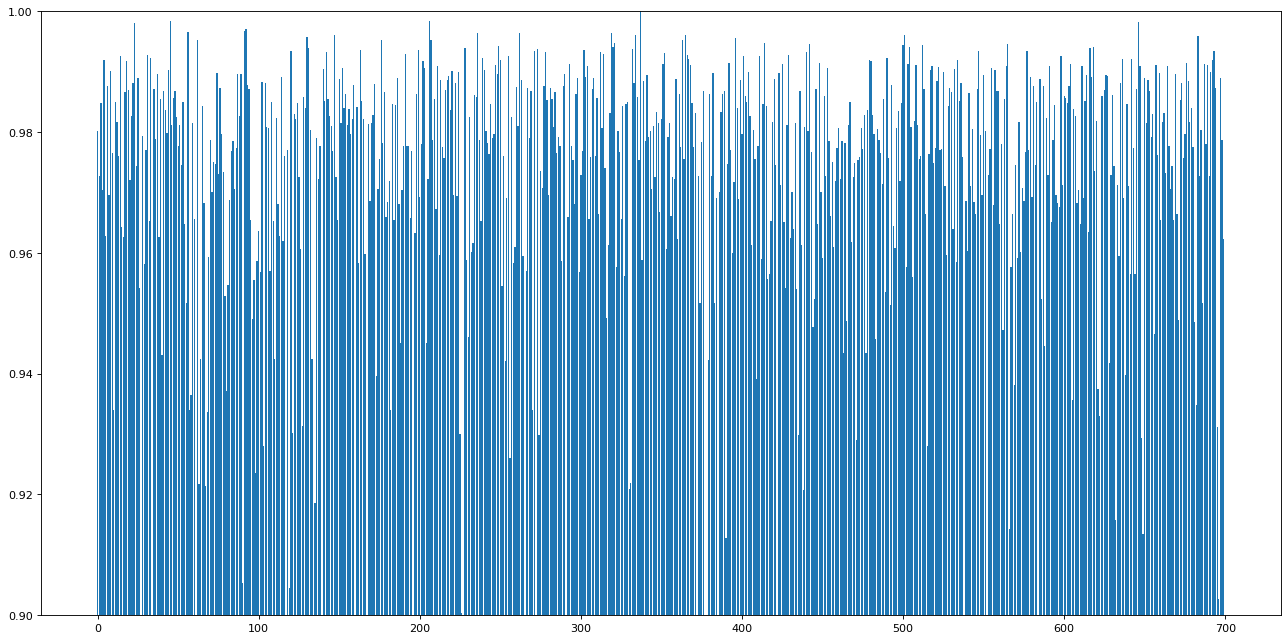

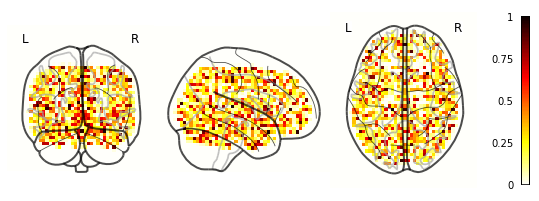

paragraph


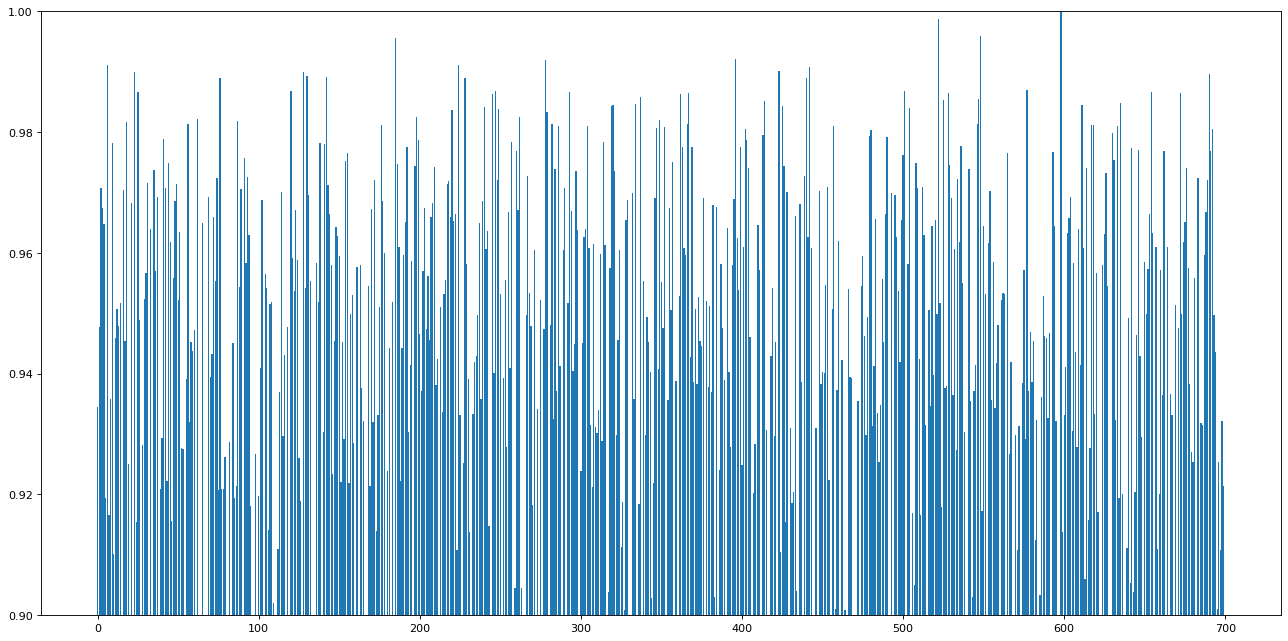

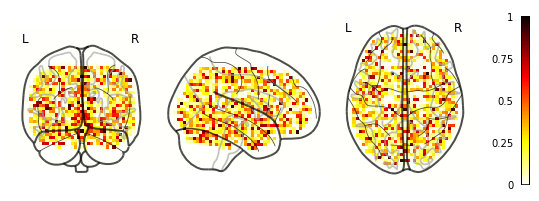

word


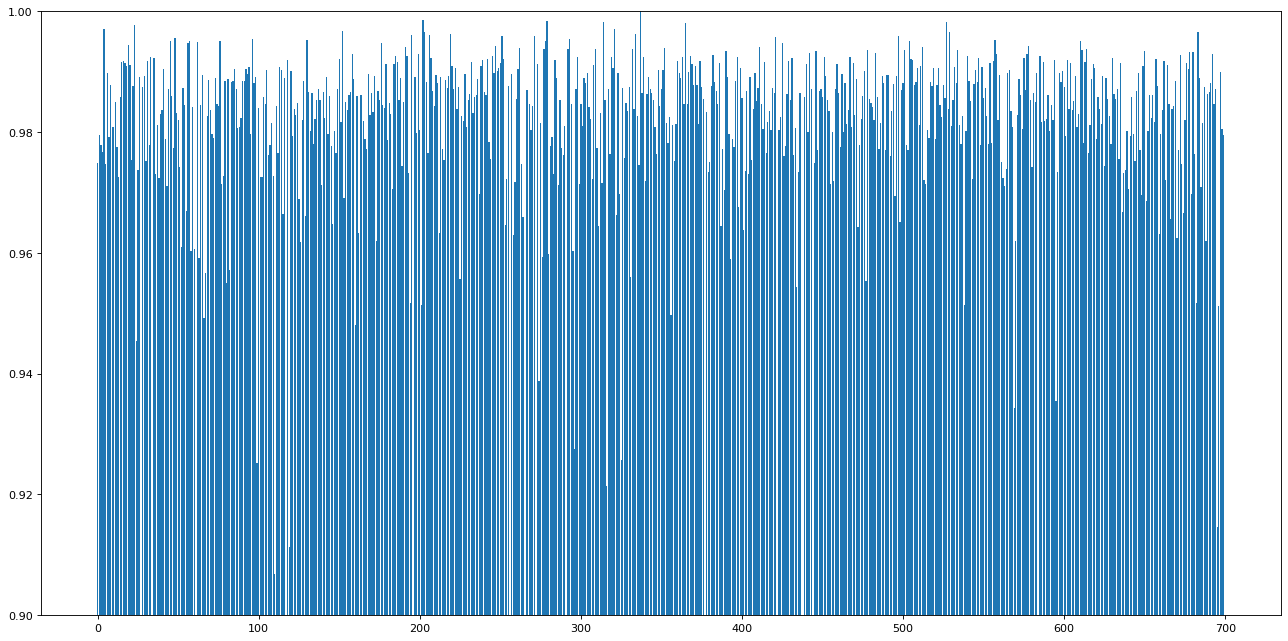

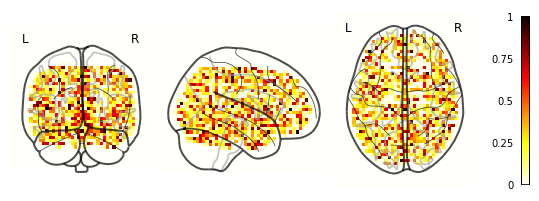

rest


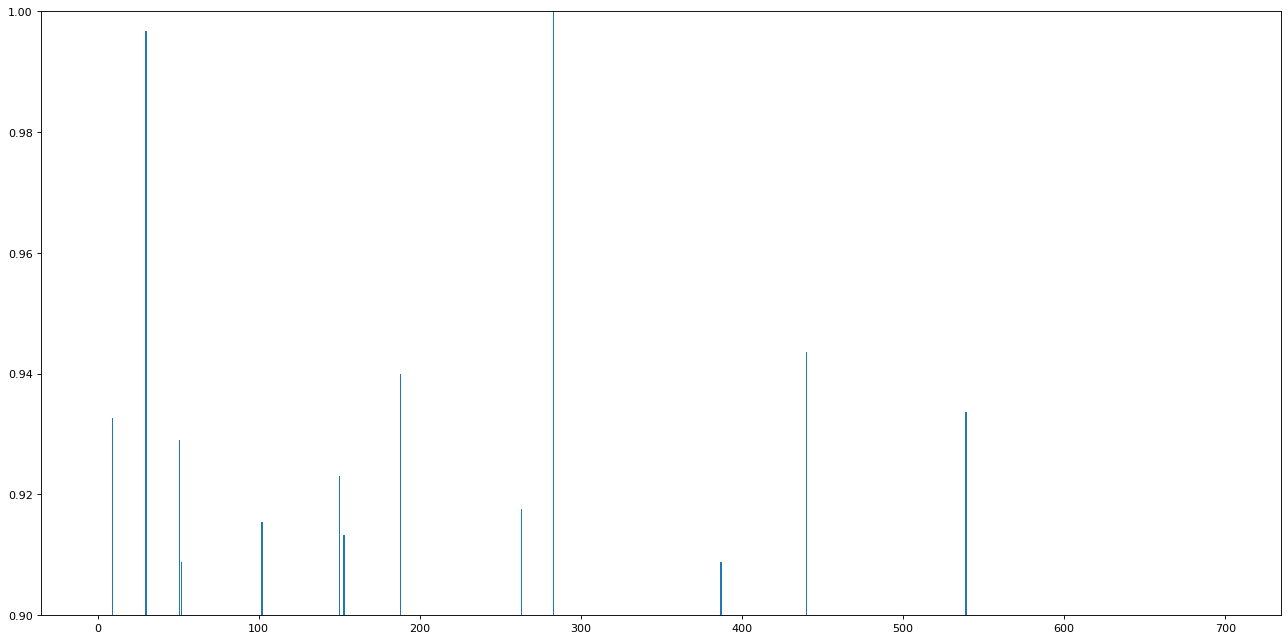

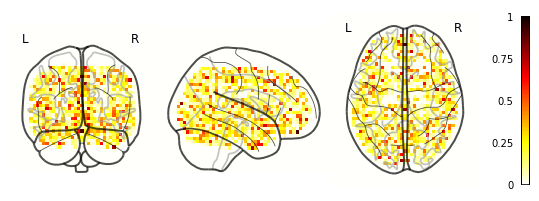

In [59]:
for c in pieman_conds:
    print(c)
    importance = find_features(data[conds == c], dims=int(factors))

    min_sub = importance - importance.min()
    importance_normed = min_sub/(importance.max() - importance.min())
#     for i, v in enumerate(importance_normed):
#         print('Feature: %0d, Score: %.5f' % (i, v))
        
    pyplot.figure(figsize=(20, 10), dpi=80)
    pyplot.bar([x for x in range(len(importance_normed))], importance_normed)
    pyplot.ylim([.9, 1])
    pyplot.show()
    
    interp_corr(centers,  np.atleast_2d(importance_normed), width=4, vox_size=4, outfile=None, save_nii=None)
    plt.show()

In [104]:
template = se.helpers._std(res=4)

In [111]:
importance

array([0.99988824, 0.99989543, 0.99988745, 0.99986968, 0.9999264 ,
       0.9998465 , 0.99992965, 0.99984999, 0.99992399, 0.99996146,
       0.99985253, 0.99985231, 0.99989858, 0.99977965, 0.99989935,
       0.99993037, 0.99990159, 0.99992351, 0.99993517, 0.99994969,
       0.99986821, 0.99995183, 0.99990706, 0.99994274, 0.99976794,
       0.99990298, 0.99988087, 0.9998763 , 0.99988026, 0.99990525,
       0.99997541, 0.99989292, 0.99990163, 0.99989669, 0.99988315,
       0.99991762, 0.99986737, 0.99991833, 0.9999202 , 0.99989783,
       0.99992426, 0.99990283, 0.99987916, 0.99989568, 0.99991618,
       0.99989724, 0.99986057, 0.99986652, 0.99987235, 0.99990173,
       0.99986899, 0.99996065, 0.99995628, 0.99982995, 0.99990214,
       0.99989964, 0.99989708, 0.99989404, 0.99988124, 0.99992322,
       0.99990835, 0.99990904, 0.99989164, 0.99985759, 0.99991602,
       0.99992738, 0.99978832, 0.99986165, 0.99986907, 0.99986685,
       0.99992367, 0.99991734, 0.99984587, 0.9999234 , 0.99992

In [127]:
c = 'intact'
importance = find_features(data[conds == c], dims=int(factors))

min_sub = importance - importance.min()
importance_normed = min_sub/(importance.max() - importance.min())

In [128]:
net_inds = largest_indices(importance, 20)

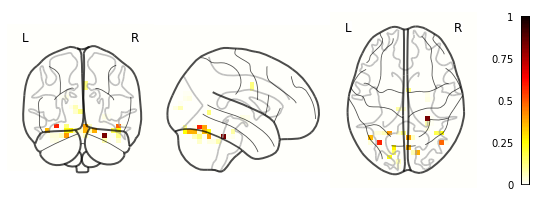

In [129]:
interp_corr(centers[net_inds],  np.atleast_2d(importance_normed[net_inds]), width=6, vox_size=6, outfile=None, save_nii=None)

In [133]:
correlation - assigned importance and pca - or rank or eigenvalue

0.999996534499533

intact


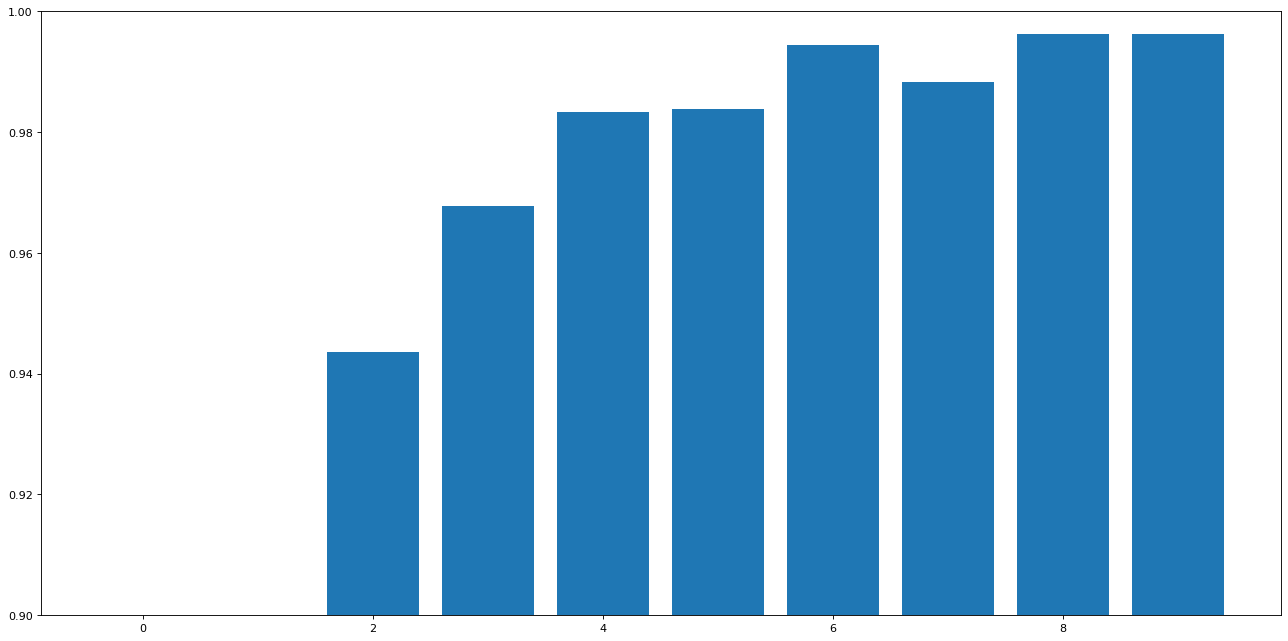

ValueError: shapes (1,10) and (700,30665) not aligned: 10 (dim 1) != 700 (dim 0)

In [134]:
for c in pieman_conds:
    print(c)
    importance = find_features(data[conds == c], dims=int(factors))

    min_sub = importance - importance.min()
    importance_normed = min_sub/(importance.max() - importance.min())
#     for i, v in enumerate(importance_normed):
#         print('Feature: %0d, Score: %.5f' % (i, v))
        
    pyplot.figure(figsize=(20, 10), dpi=80)
    pyplot.bar([x for x in range(len(importance))], importance)
    pyplot.ylim([.9, 1])
    pyplot.show()
    
    interp_corr(centers,  np.atleast_2d(importance_normed), width=4, vox_size=4, outfile=None, save_nii=None)
    plt.show()

    net_inds = largest_indices(importance_normed, 50)
    temp_locs = centers[net_inds]
    temp_widths = widths[net_inds]
    w = rbf(temp_locs, temp_widths, centers)
    b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=centers, minimum_voxel_size=2)

    b_data = b_o.get_data().values.ravel()
    xyz = b_o.get_locs().values
    mask = b_data > .5
    xyz = xyz[mask]
    b_data = b_data[mask]
    b_data = np.ones(b_data.shape)+i

    b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
    b.filter = None
    b.plot_locs()
    #outfile = os.path.join(pca_nii_bo_dir, c + '_' + str(i+1) + '_pca')
    #b.save(outfile)

    nii = se.helpers._brain_to_nifti(b, template)
    nii.get_data()[nii.get_data() > 0] = 1
    #nii = se.Nifti(b_o, affine = template.get_affine())
    #print('Condition = ' + c + '; PCA = ' + str(i+ 1) + '; Variance explained = ' + str(np.round(pca.explained_variance_ratio_[i],2)))
    nii.plot_glass_brain()

In [76]:
importance_all = np.array([])
importance_val = np.array([])
for e, c in enumerate(pieman_conds):
    print(e + 1)
    importance = find_features(data[conds == c], dims=int(100))
    cat_vals = np.array([e+1] * importance.shape[0])
    if importance_all is None:
        importance_all = importance
        importance_val = cat_vals
    else:
        importance_all = np.append(importance_all, [importance])
        importance_val = np.append(importance_val, [cat_vals])

1
2
3
4


In [93]:
importance_val = (importance_val - 4) * -1

In [96]:
rho, pval = scipy.stats.spearmanr(importance_all[importance_val>0], importance_val[importance_val>0])

In [97]:
rho

0.21986428996860777

In [98]:
pval

0.0001233619761803696